In [7]:
%pip install seaborn
%pip install optuna
%pip install optuna-integration
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install lightning
%pip install tensorflow
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib
%pip install plotly
%pip install xgboost
%pip install cupy-cuda12x
%pip install shap
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

In [8]:
# Standard library imports
from collections import defaultdict
from datetime import datetime, timedelta

# Third-party library imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import torchmetrics
import shap


from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_intermediate_values
)
from scipy import stats
from scipy.sparse import issparse
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split
import ipywidgets as widgets
from IPython.display import display


Number of rows before dropping NaN values: 7760
Number of rows after dropping NaN values: 7743


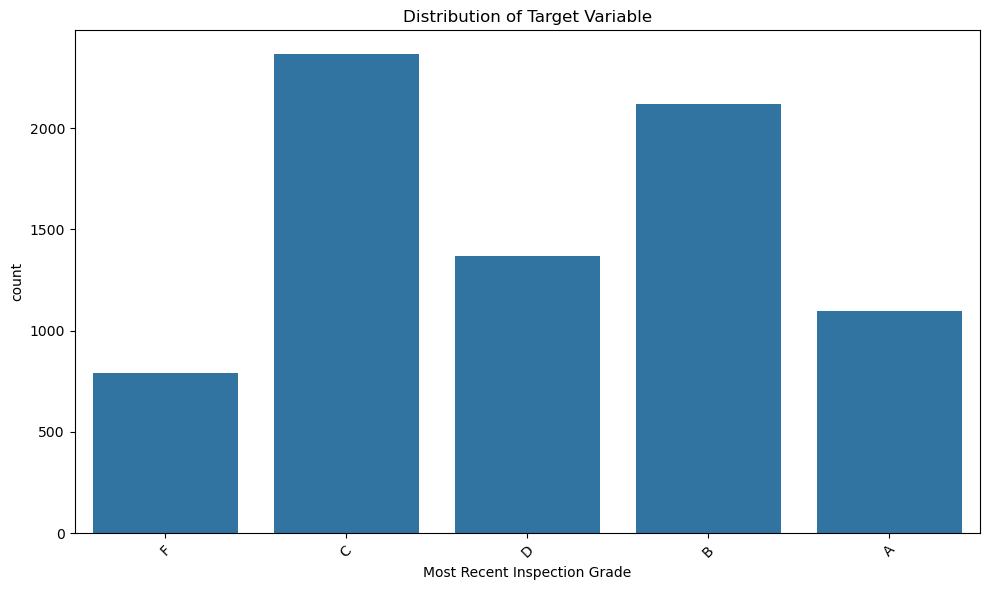

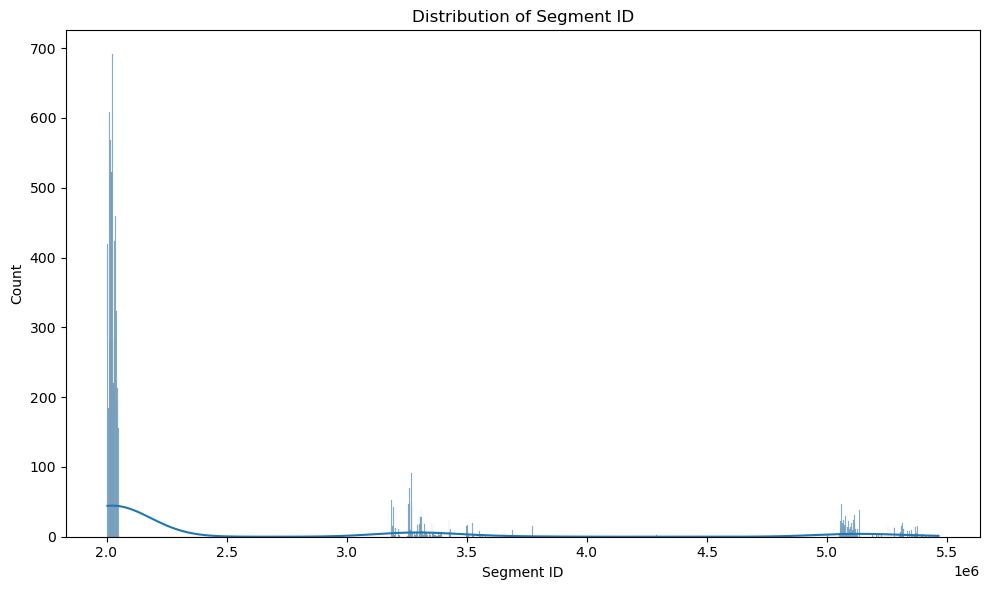

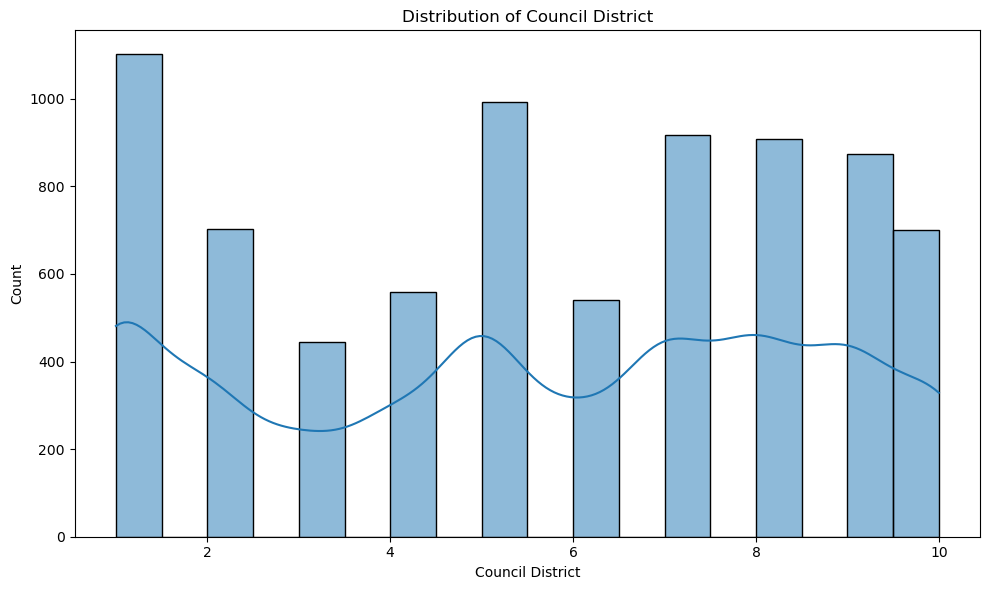

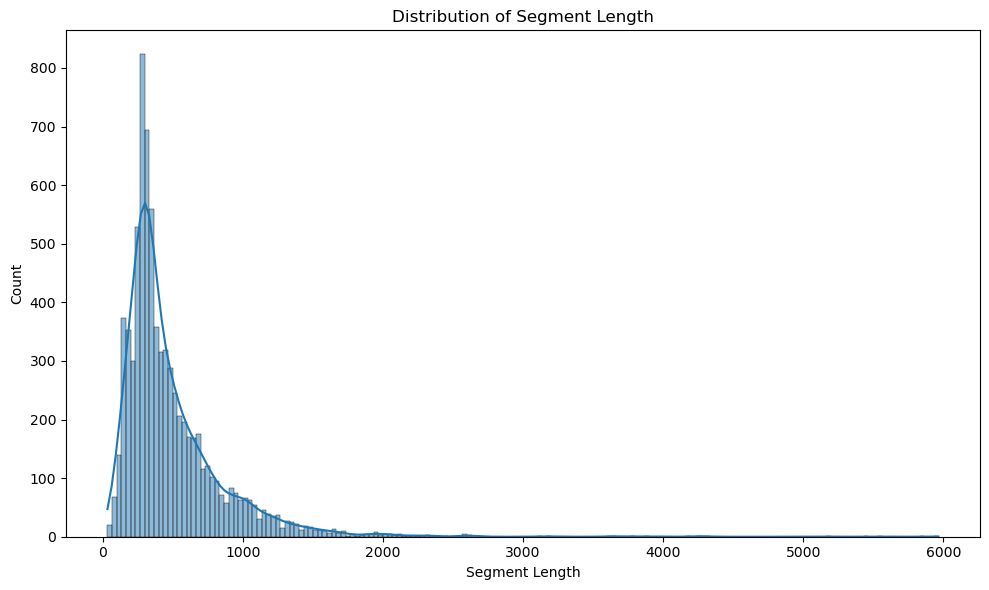

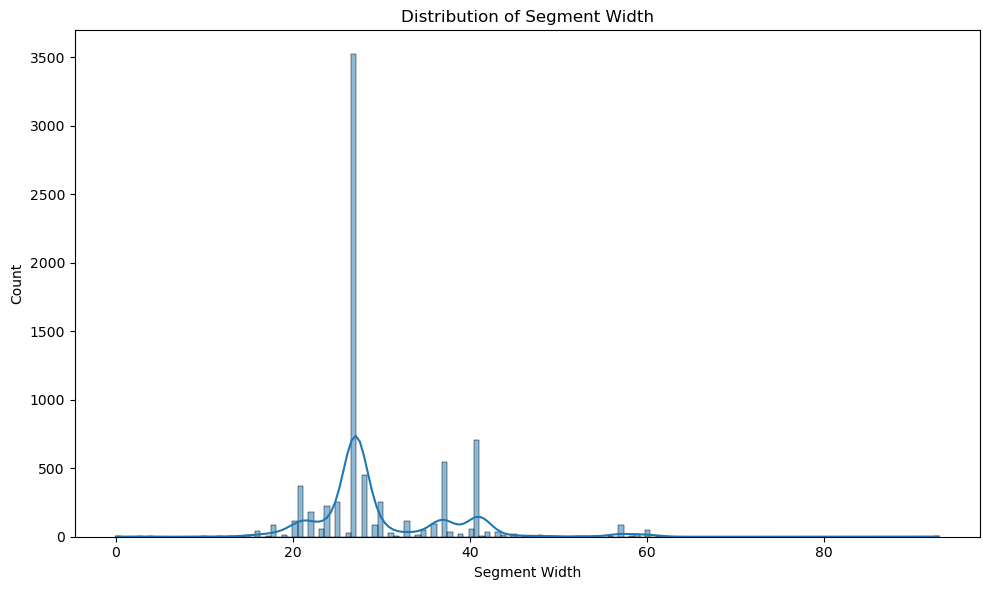

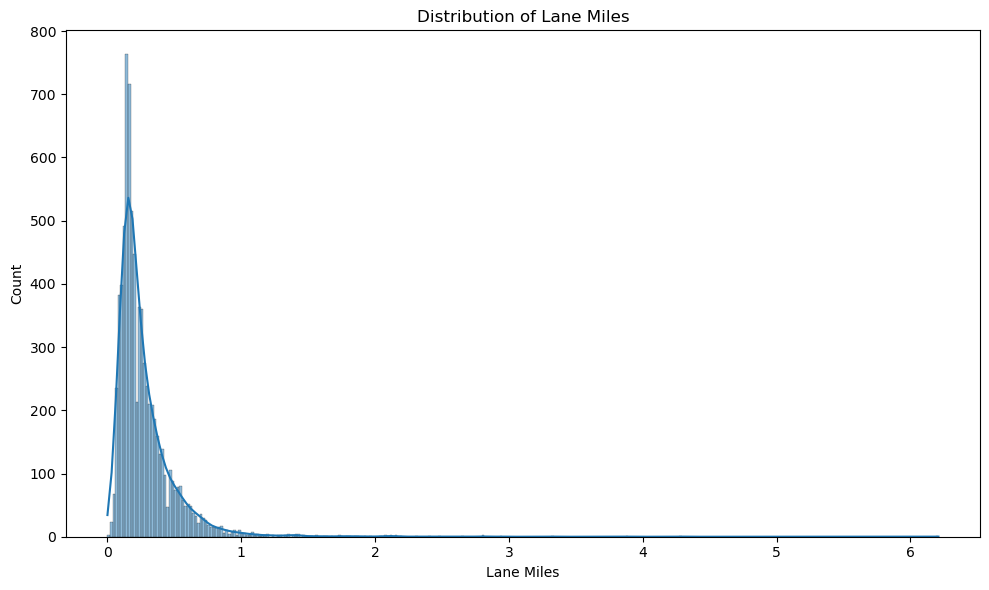

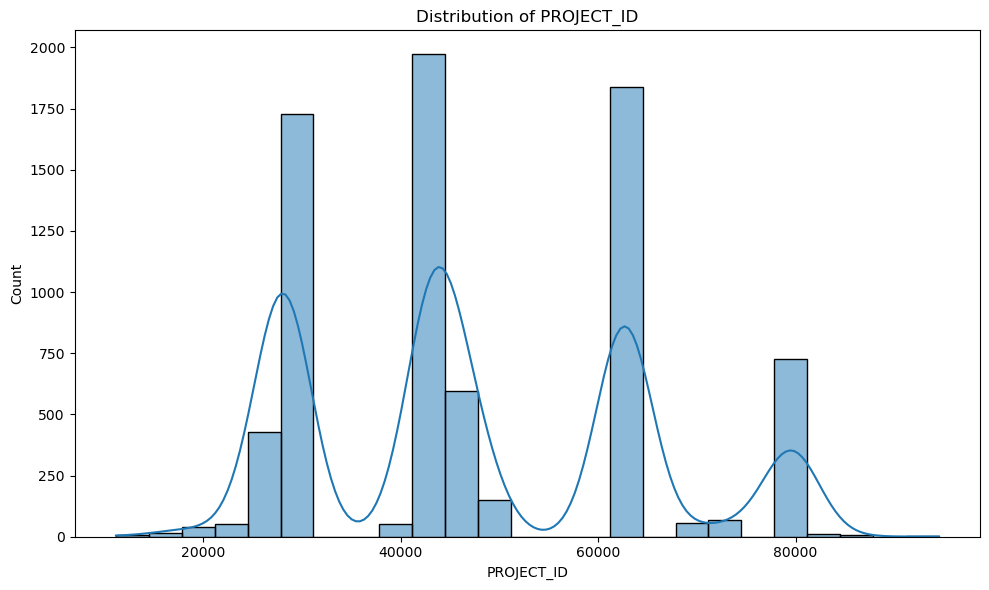

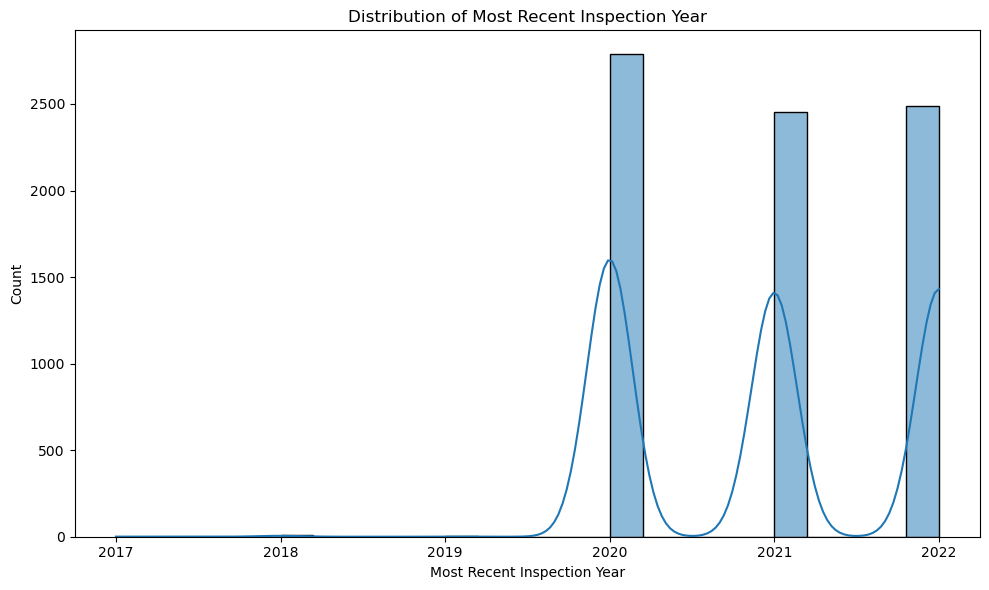

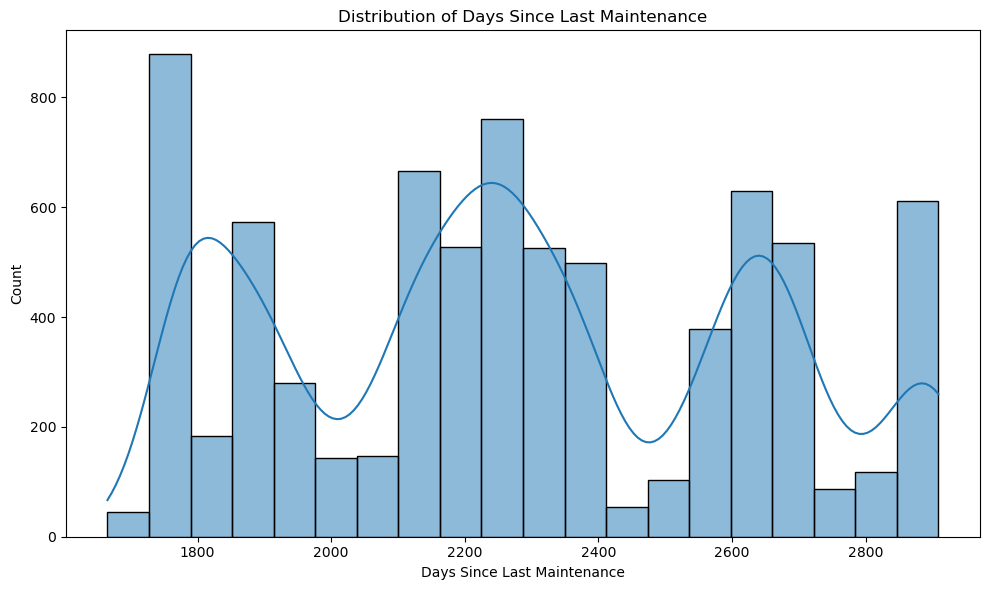

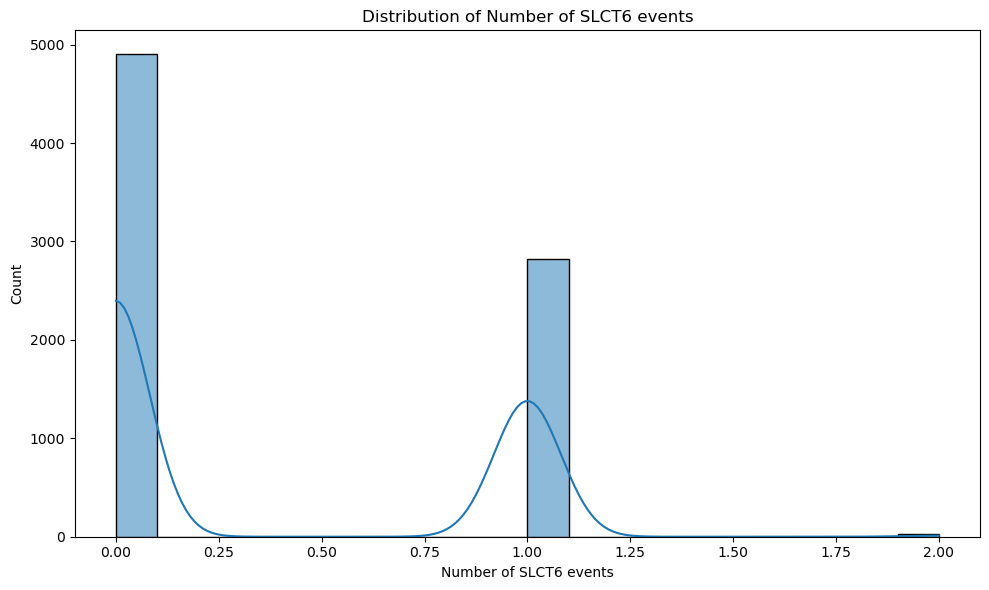

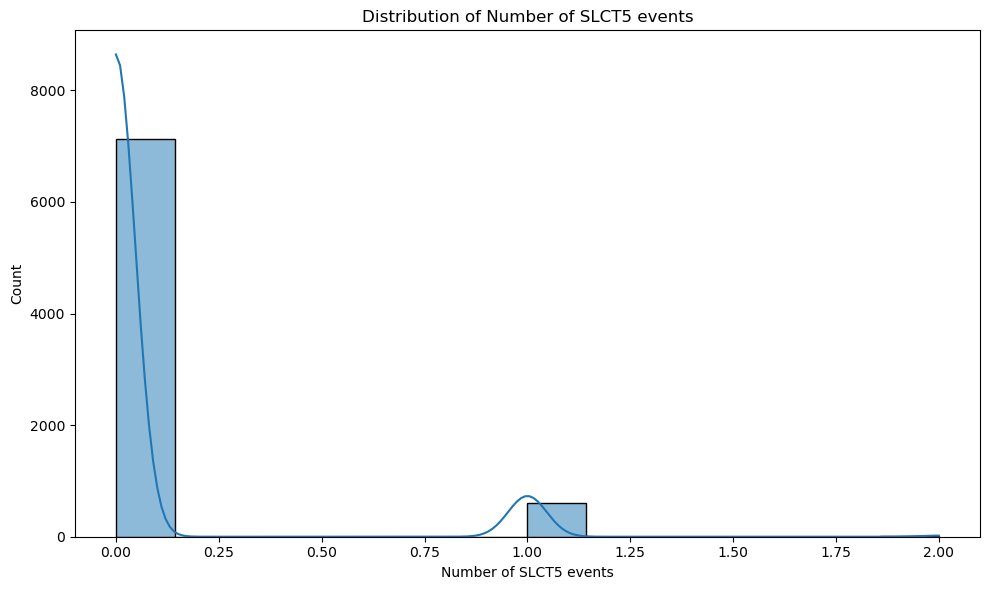

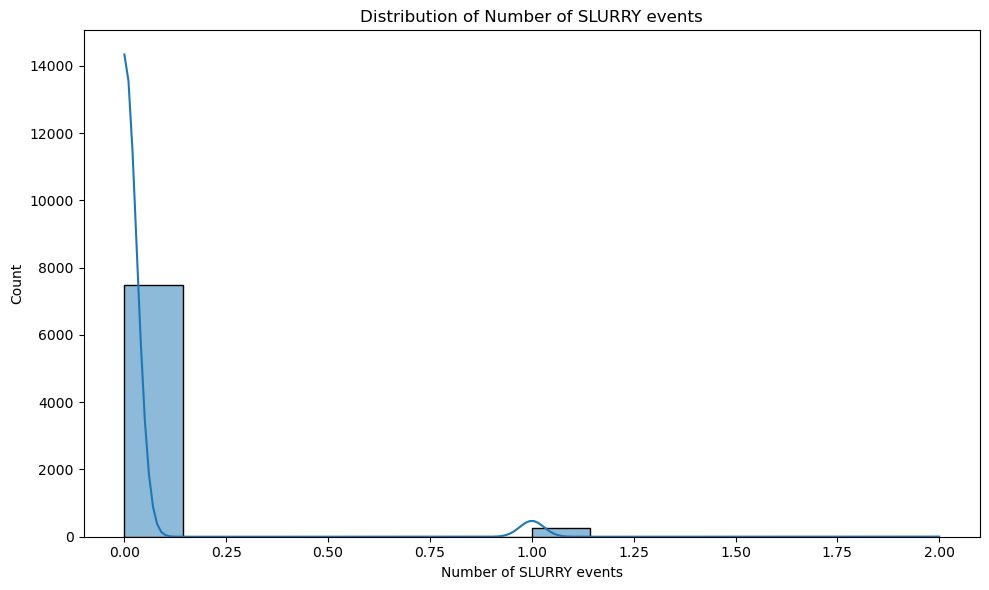

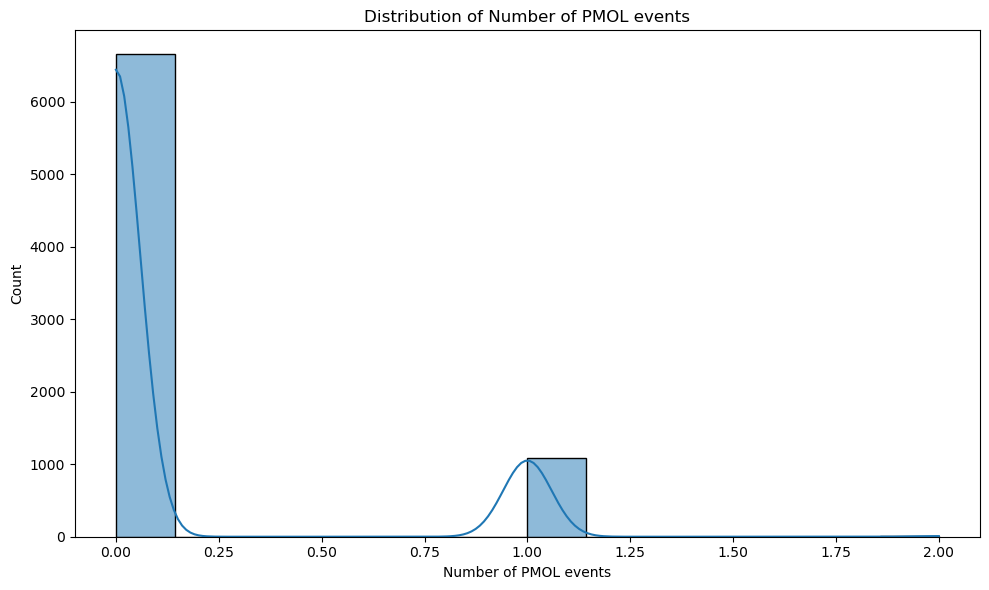

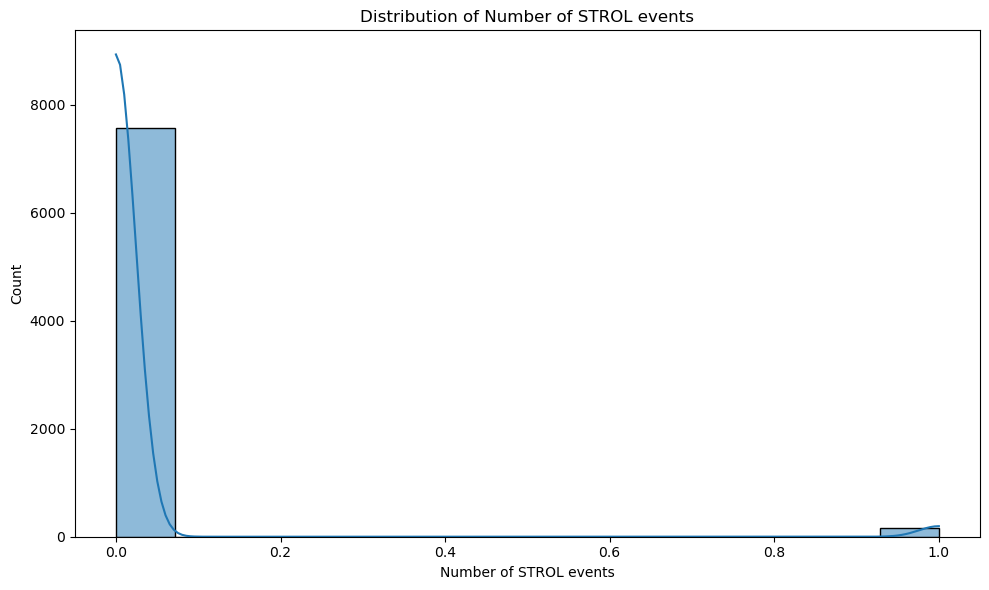

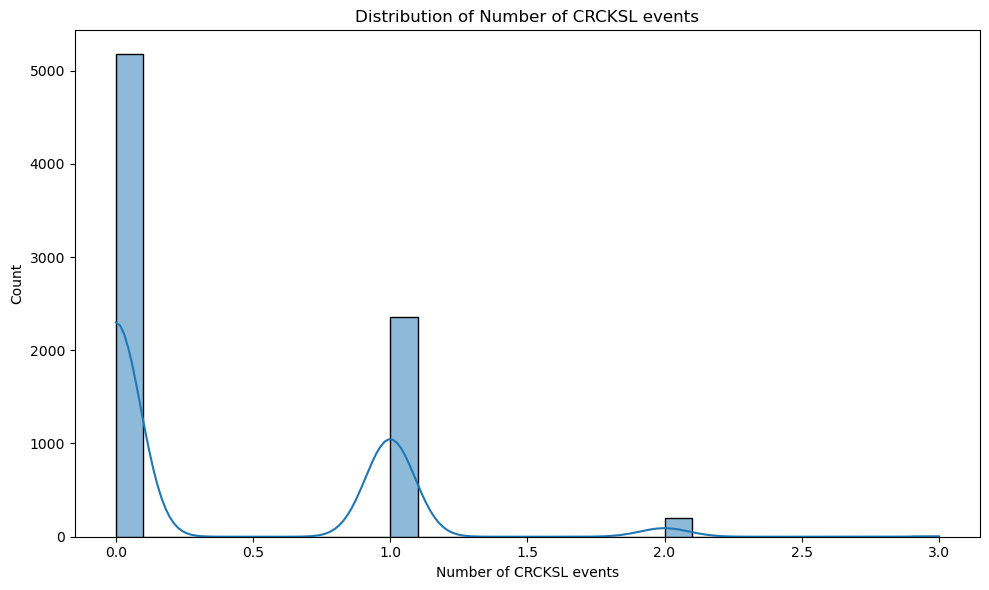

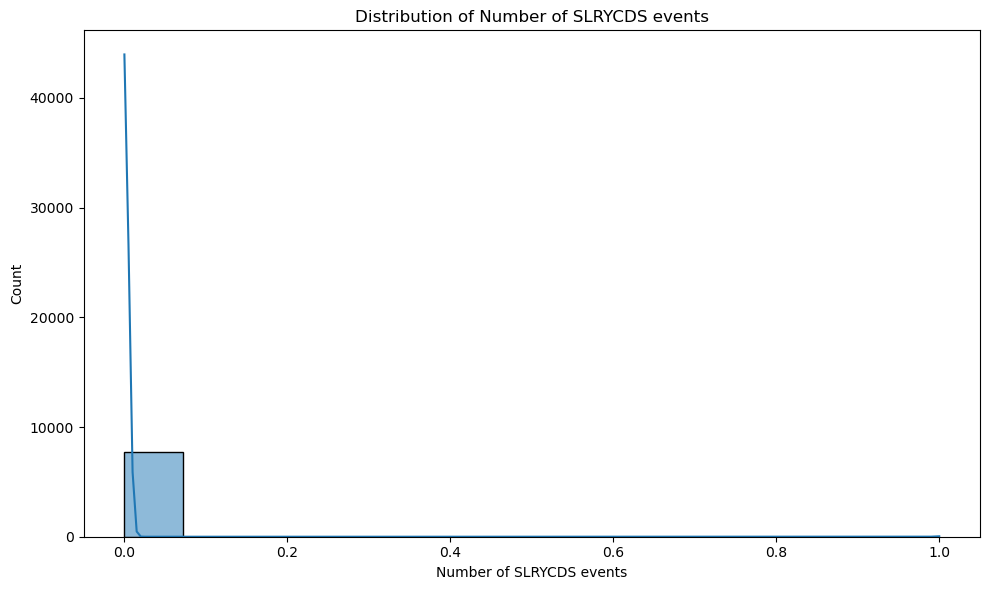

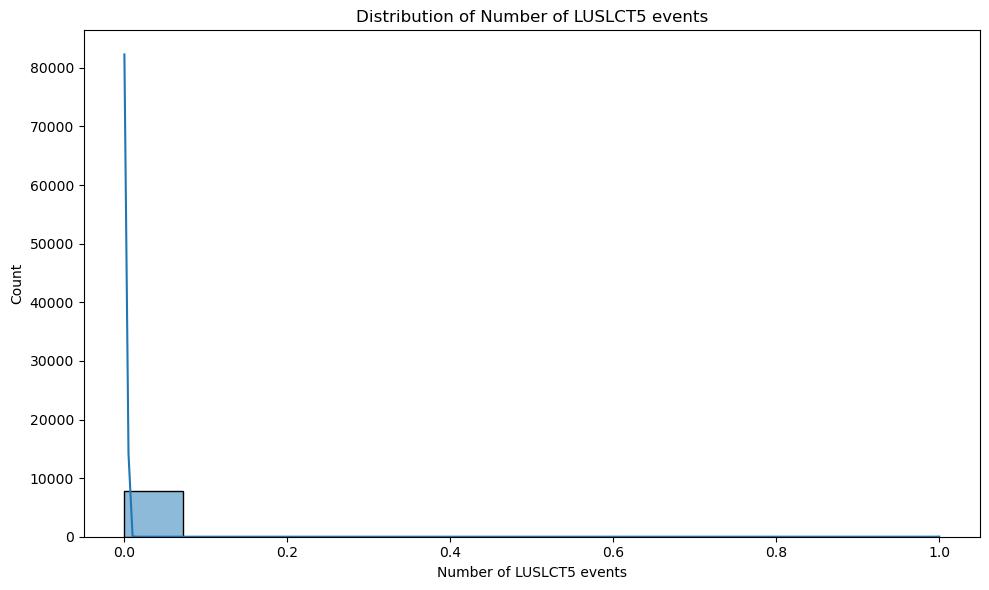

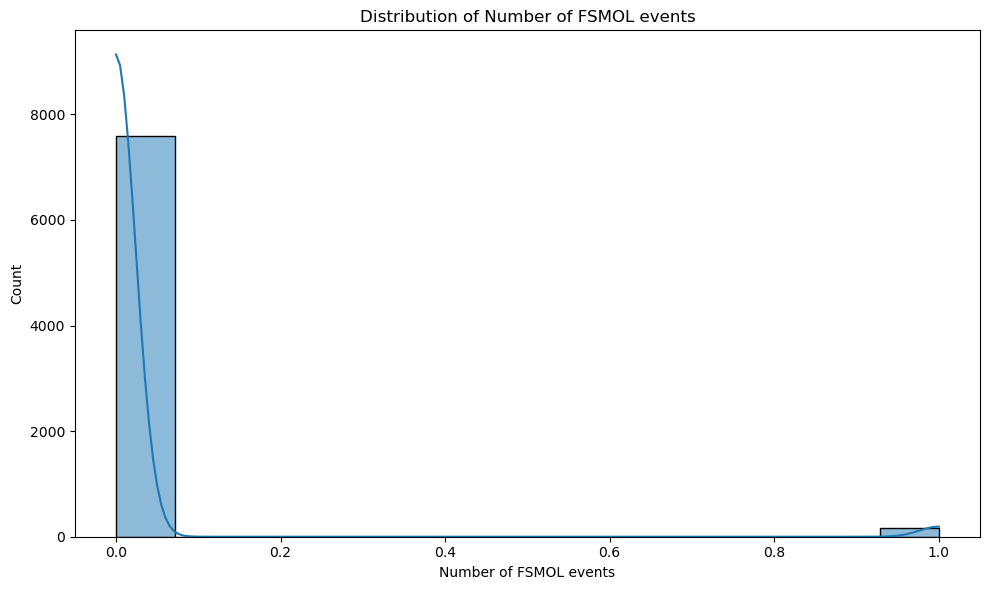

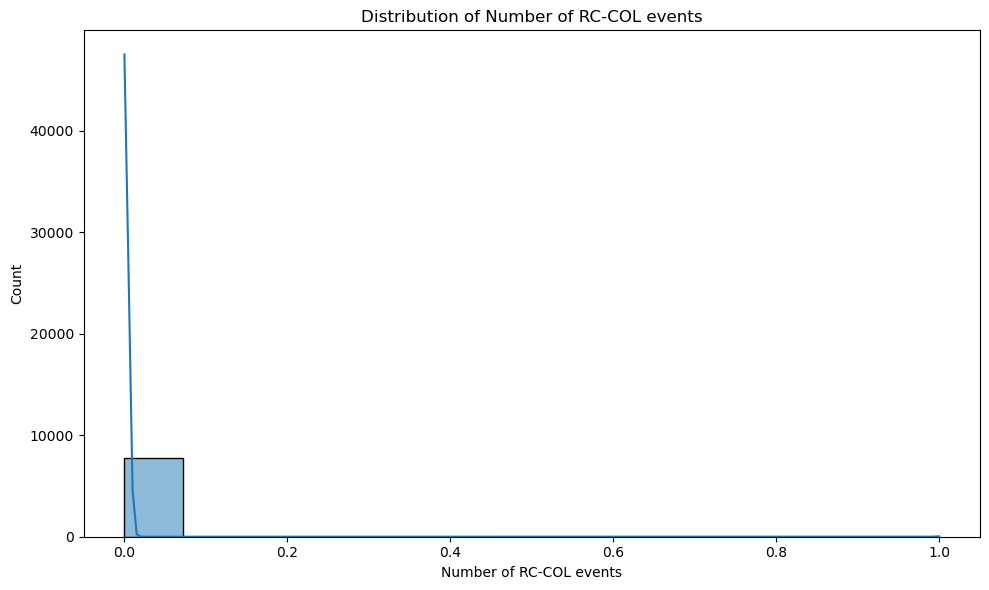

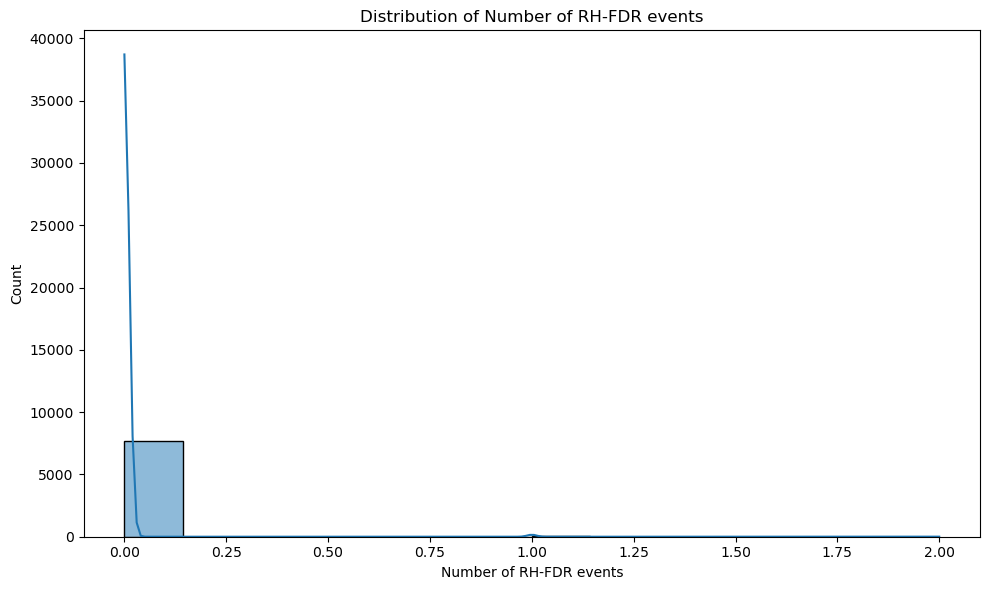

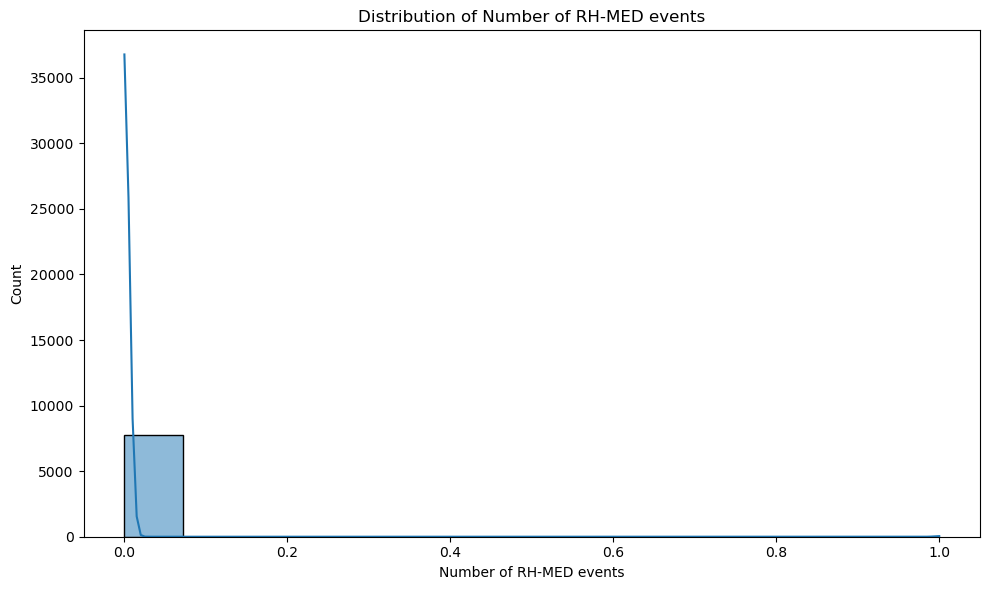

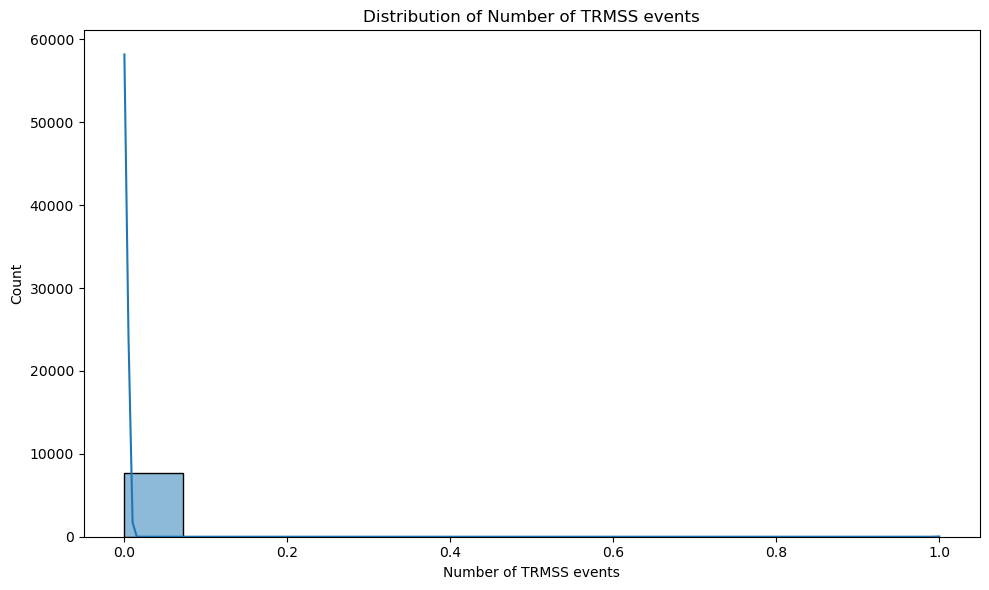

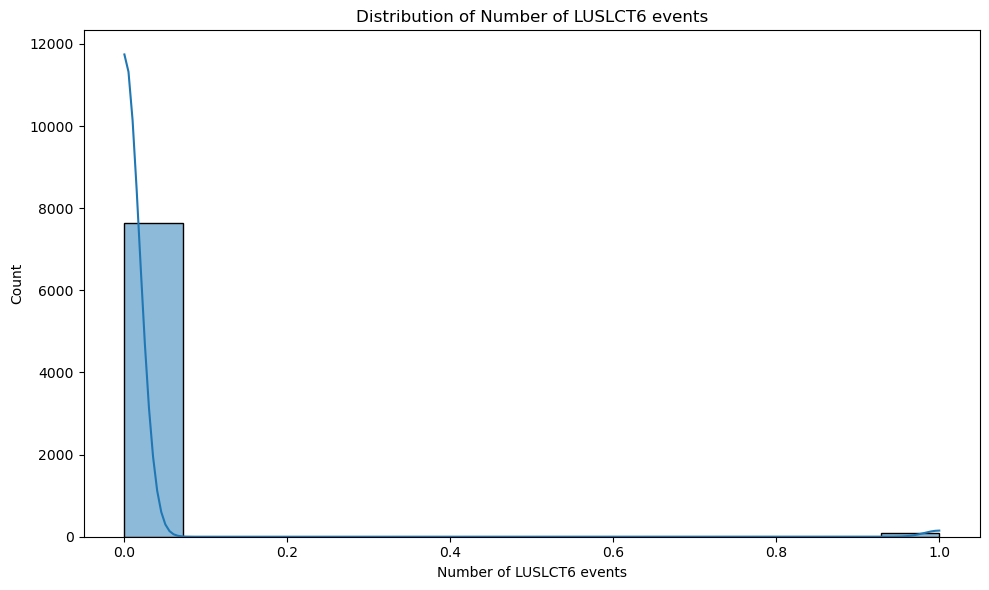

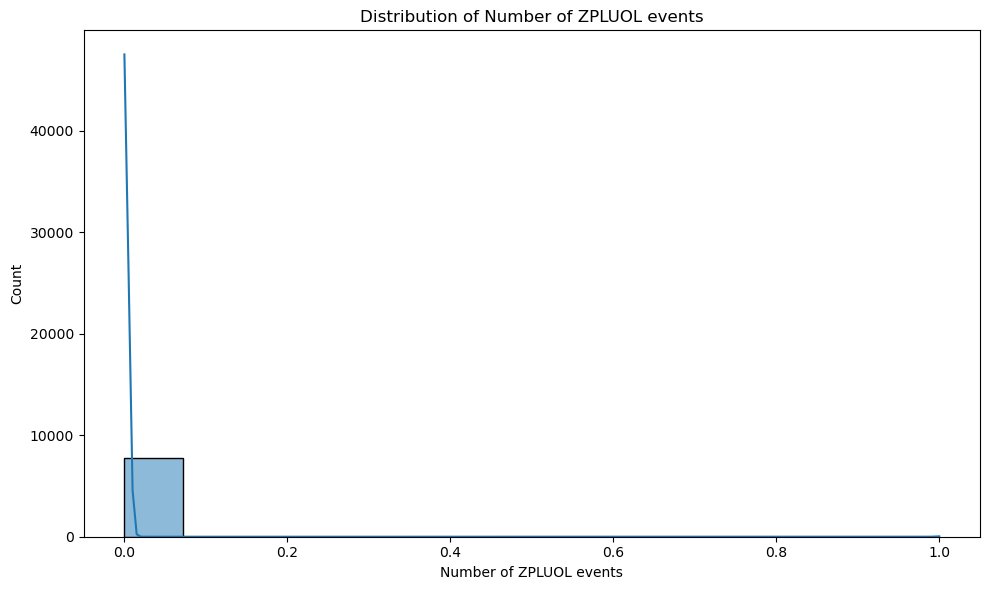

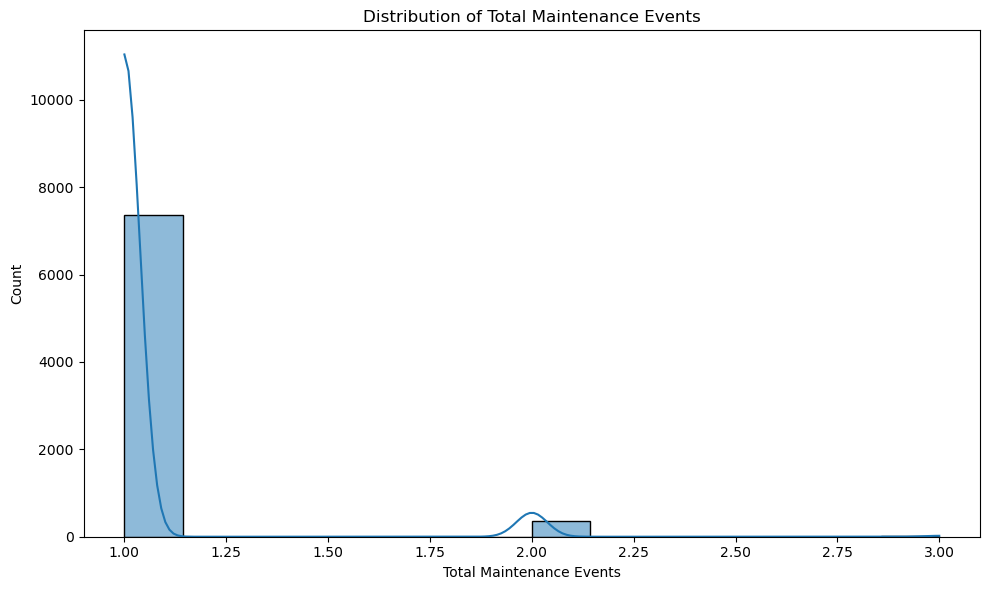

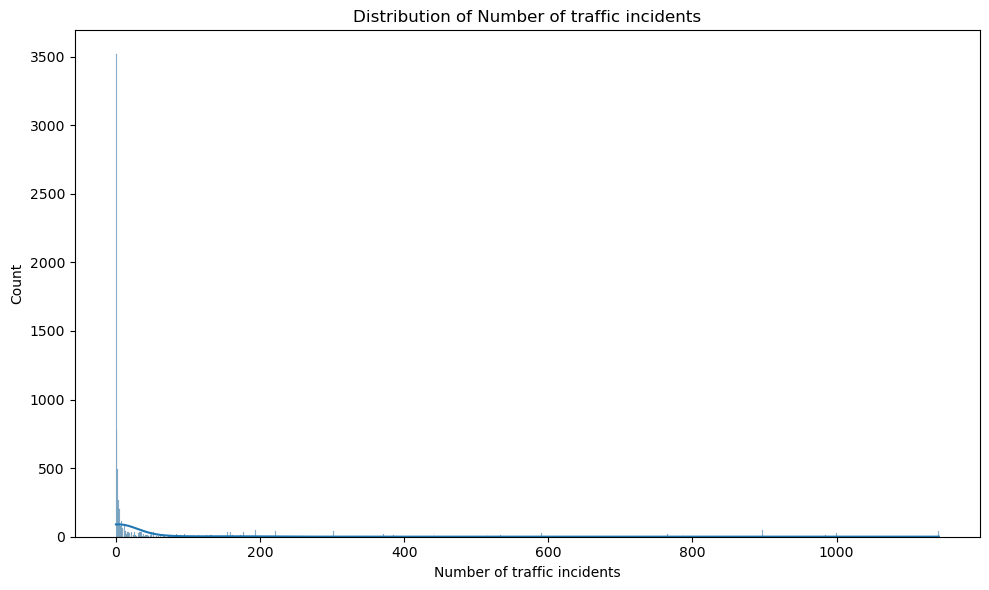

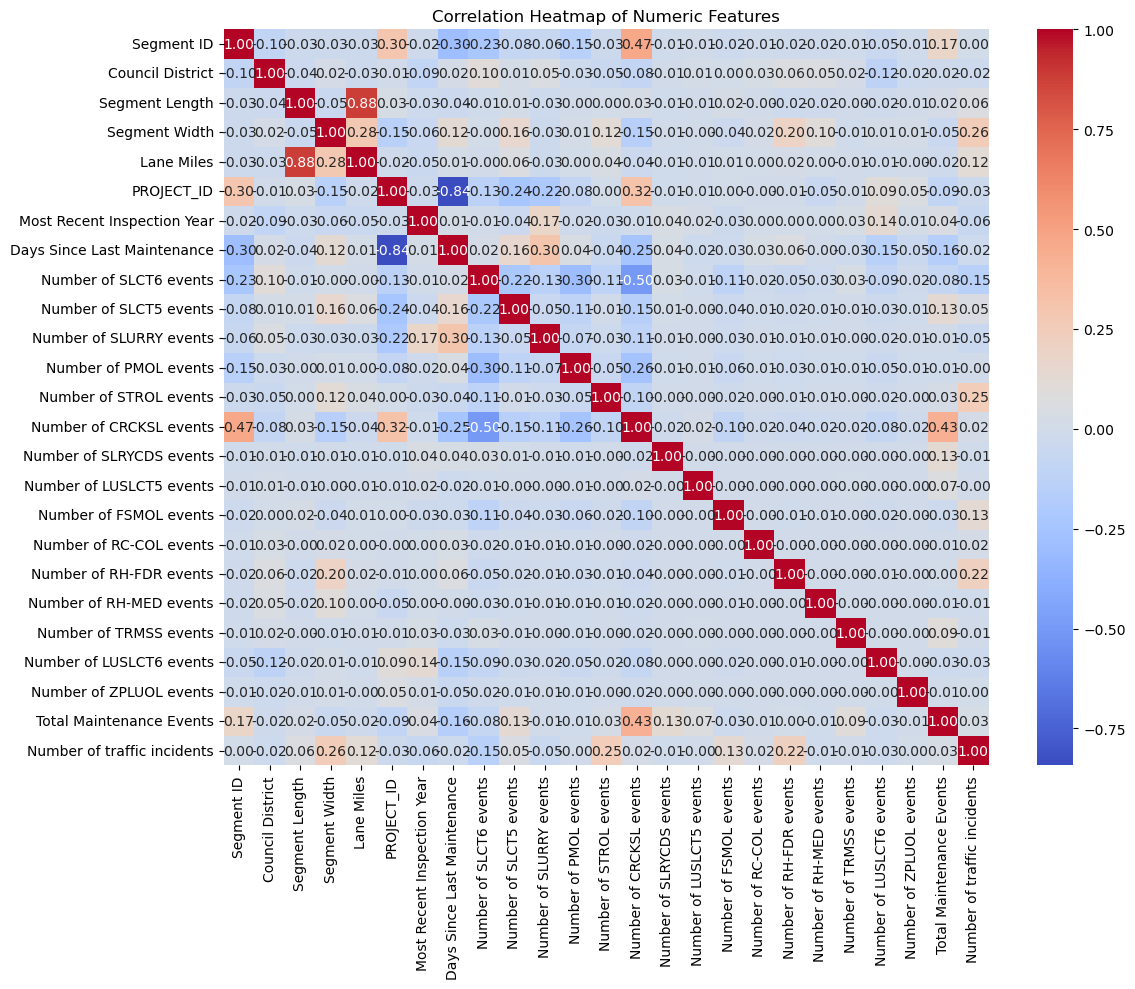


Top 10 Feature Correlations (excluding specified pairs):
Lane Miles - Segment Length: 0.88
Number of traffic incidents - Segment Width: 0.26
Number of traffic incidents - Number of STROL events: 0.25
Number of traffic incidents - Number of RH-FDR events: 0.22
Segment Width - Number of RH-FDR events: 0.20
Number of SLURRY events - Most Recent Inspection Year: 0.17
Number of SLCT5 events - Segment Width: 0.16
Days Since Last Maintenance - Number of SLCT5 events: 0.16
Number of LUSLCT6 events - Most Recent Inspection Year: 0.14
Number of SLCT5 events - Total Maintenance Events: 0.13


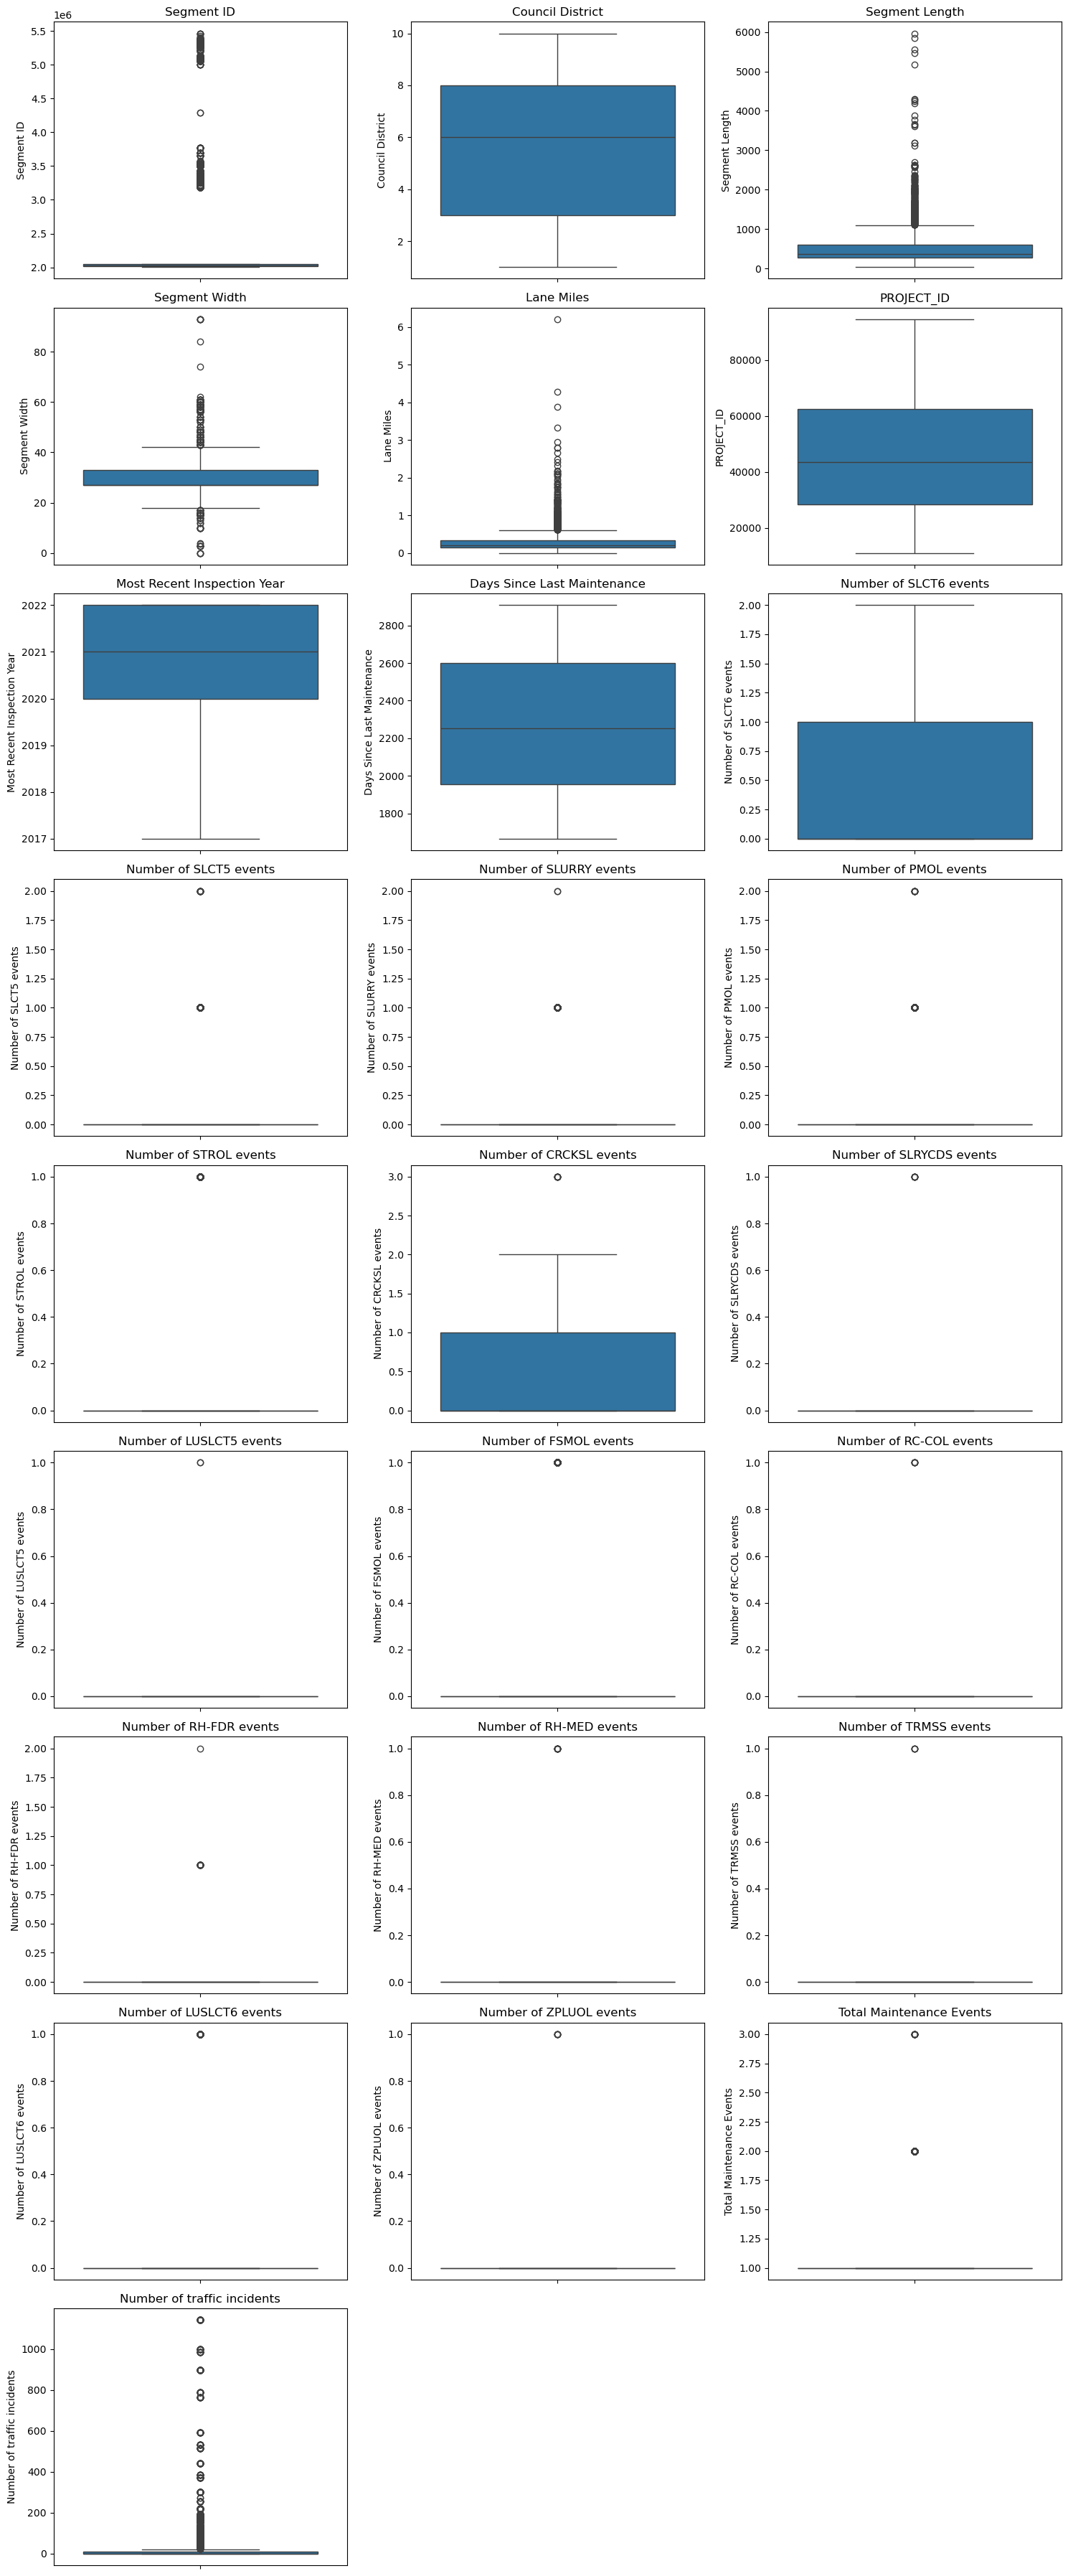


Outliers (Z-score > 3):
Segment ID                     139
Council District                 0
Segment Length                 112
Segment Width                  208
Lane Miles                     102
PROJECT_ID                       0
Most Recent Inspection Year     10
Days Since Last Maintenance      0
Number of SLCT6 events          23
Number of SLCT5 events         618
Number of SLURRY events        249
Number of PMOL events            9
Number of STROL events         166
Number of CRCKSL events        214
Number of SLRYCDS events         7
Number of LUSLCT5 events         2
Number of FSMOL events         159
Number of RC-COL events          6
Number of RH-FDR events         33
Number of RH-MED events         10
Number of TRMSS events           4
Number of LUSLCT6 events        97
Number of ZPLUOL events          6
Total Maintenance Events       380
Number of traffic incidents    232
dtype: int64

Top 10 Features by F-score:
Segment Length                 67.709265
Segment ID       

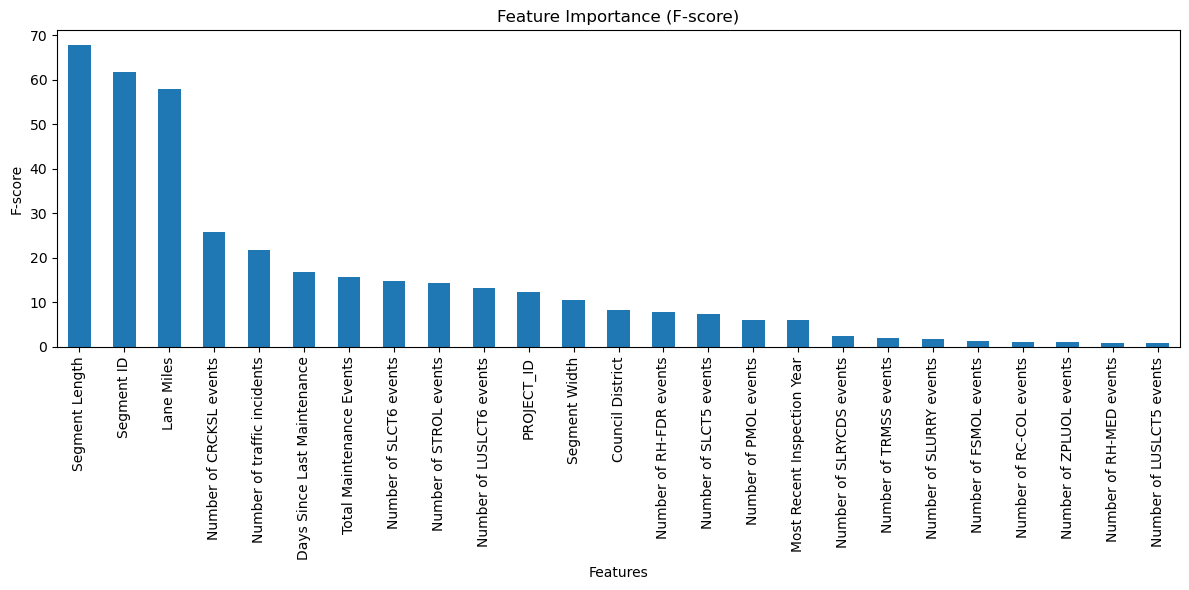

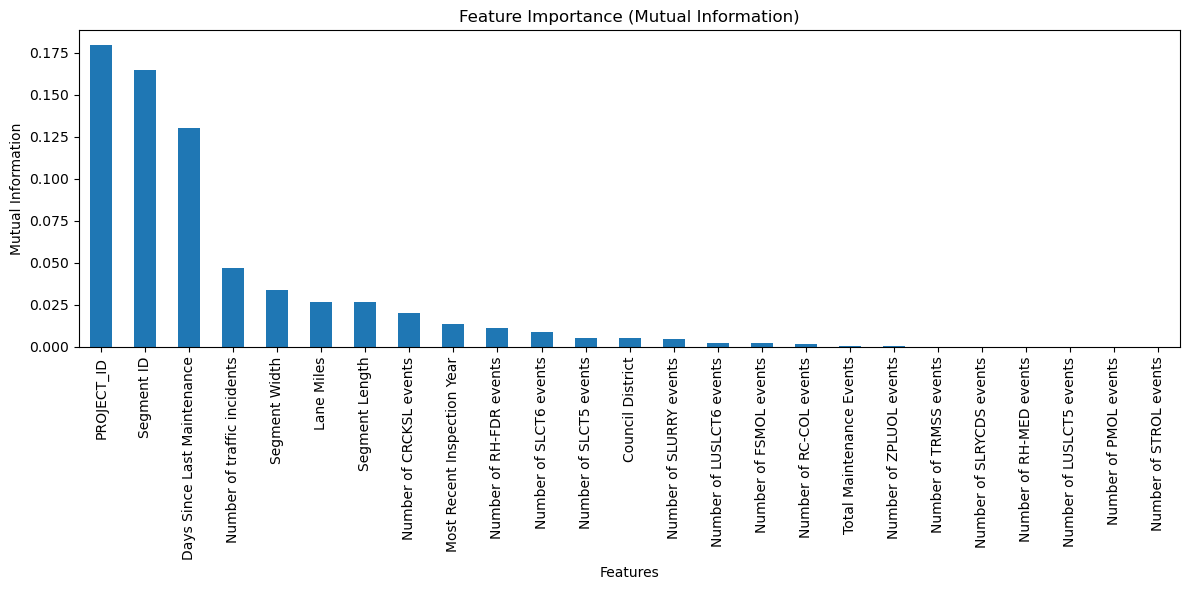

In [9]:

# Data preprocessing




# Load the prepared dataset
df = pd.read_csv('filtered_work_done_with_inspections_and_treatments.csv')

# Print the number of rows before dropping NaN values
print(f"Number of rows before dropping NaN values: {len(df)}")

# Drop rows with NaN values
df = df.dropna()

# Print the number of rows after dropping NaN values
print(f"Number of rows after dropping NaN values: {len(df)}")

# Define the target variable and features
target = 'Most Recent Inspection Grade'
features = df.drop(columns=[target])

# Handle missing values and encode categorical variables
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns



# Explore distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=df)
plt.title('Distribution of Target Variable')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Explore distributions of numeric features
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

# Check correlations between numeric features
correlation_matrix = df[numeric_features].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


def get_top_correlations(corr_matrix, n=10, exclude_pairs=None):
    # Unstack the correlation matrix
    corr_unstack = corr_matrix.unstack()
    
    # Sort the correlations
    sorted_corr = corr_unstack.sort_values(kind="quicksort", ascending=False)
    
    # Remove self-correlations
    sorted_corr = sorted_corr[sorted_corr != 1.0]
    
    # Remove duplicate pairs
    sorted_corr = sorted_corr.drop_duplicates()
    
    # Remove excluded pairs
    if exclude_pairs:
        for pair in exclude_pairs:
            sorted_corr = sorted_corr[~((sorted_corr.index.get_level_values(0) == pair[0]) & 
                                        (sorted_corr.index.get_level_values(1) == pair[1])) &
                                      ~((sorted_corr.index.get_level_values(0) == pair[1]) & 
                                        (sorted_corr.index.get_level_values(1) == pair[0]))]
    
    return sorted_corr.head(n)

exclude_pairs = [
    ('Number of CRCKSL events', 'Segment ID'),
    ('Number of CRCKSL events', 'Total Maintenance Events'),
    ('Number of CRCKSL events', 'PROJECT_ID'),
    ('Segment ID', 'PROJECT_ID'),
    ('Lane Miles', 'Segment Width'),
    ('Total Maintenance Events', 'Segment ID'),
    ('Number of SLURRY events', 'Days Since Last Maintenance'),


]

# Get and print top 10 correlations, excluding specified pairs
top_correlations = get_top_correlations(correlation_matrix, n=10, exclude_pairs=exclude_pairs)
print("\nTop 10 Feature Correlations (excluding specified pairs):")
for (feature1, feature2), correlation in top_correlations.items():
    print(f"{feature1} - {feature2}: {correlation:.2f}")


n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(feature)

for j in range(i+1, len(axes)):
    axes[j].remove()

plt.tight_layout()
plt.show()

# Z-score outlier detection
z_scores = np.abs(stats.zscore(df[numeric_features]))
print("\nOutliers (Z-score > 3):")
print((z_scores > 3).sum())

# Define the target variable and features
target = 'Most Recent Inspection Grade'
features = df.drop(columns=[target])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

def get_feature_names(column_transformer):
    feature_names = []
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if isinstance(pipe, Pipeline):
                if isinstance(pipe.steps[-1][1], OneHotEncoder):
                    feature_names.extend(pipe.named_steps['onehot'].get_feature_names_out(features))
                else:
                    feature_names.extend(features)
            elif isinstance(pipe, OneHotEncoder):
                feature_names.extend(pipe.get_feature_names_out(features))
            else:
                feature_names.extend(features)
    return feature_names



# Fit and transform the data
X = preprocessor.fit_transform(features)
y = df[target]

# Generate feature names after fitting
feature_names = get_feature_names(preprocessor)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


# Function to get feature importance scores
def get_feature_importance(X, y, method='f_classif'):
    if method == 'f_classif':
        f_scores, _ = f_classif(X, y)
        return pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
    elif method == 'mutual_info':
        mi_scores = mutual_info_classif(X, y)
        return pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Get feature importance using F-score
f_importance = get_feature_importance(df[numeric_features], df[target], method='f_classif')

# Get feature importance using mutual information
mi_importance = get_feature_importance(df[numeric_features], df[target], method='mutual_info')

# Print top 10 features by F-score
print("\nTop 10 Features by F-score:")
print(f_importance.head(10))

# Print top 10 features by Mutual Information
print("\nTop 10 Features by Mutual Information:")
print(mi_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 6))
f_importance.plot(kind='bar')
plt.title('Feature Importance (F-score)')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
mi_importance.plot(kind='bar')
plt.title('Feature Importance (Mutual Information)')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()


In [10]:
# Initialize variables and prepare data


# Handle missing values in y_train and y_test
y_train_clean = y_train.fillna('Unknown')
y_test_clean = y_test.fillna('Unknown')

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_clean)
y_test_encoded = le.transform(y_test_clean)

# Get the number of classes
num_classes = len(le.classes_)
print("Number of classes:", num_classes)
print("Classes:", le.classes_)

# Convert data to PyTorch tensors
if issparse(X_train):
    X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
else:
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Create DataLoader objects
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Adjust batch size for the full dataset (you may need to experiment with this)
batch_size = 256  # Increased batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Number of classes: 5
Classes: ['A' 'B' 'C' 'D' 'F']


In [11]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Create the dropdown widget
asset_dropdown = widgets.Dropdown(
    options=['Pavement', 'Manholes', 'Markings'],
    value='Pavement',
    description='Asset:',
    disabled=False,
)

# Create the start button
start_button = widgets.Button(
    description='Start',
    disabled=False,
    button_style='success',
    tooltip='Click me',
)

# Create output widget to capture prints
output = widgets.Output()

# Define button click handler
def on_button_clicked(b):
    with output:
        print(f"Selected asset: {asset_dropdown.value}")

        # Prepare the data (RandomForest can handle sparse matrices directly)
        X_train_rf = X_train
        X_test_rf = X_test

        # Define the objective function for Optuna
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 1, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': 'balanced'
            }
            
            model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
            
            score = cross_val_score(model, X_train_rf, y_train_encoded, cv=5, scoring='accuracy')
            return score.mean()

        # Create a study object and optimize hyperparameters
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=10)

        # Print the best parameters
        print('Best trial:')
        trial = study.best_trial
        print('  Value: ', trial.value)
        print('  Params: ')
        for key, value in trial.params.items():
            print('    {}: {}'.format(key, value))

        # Train the final model with the best hyperparameters
        best_params = study.best_params
        final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
        final_model.fit(X_train_rf, y_train_encoded)

        # Evaluate the model
        y_pred = final_model.predict(X_test_rf)
        accuracy = accuracy_score(y_test_encoded, y_pred)
        print(f"Accuracy: {accuracy:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

        # Confusion Matrix
        cm = confusion_matrix(y_test_encoded, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Learning curve function remains the same
        def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1):
            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, 
                train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
            )
            
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)
            test_std = np.std(test_scores, axis=1)
            
            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_mean, label='Training score')
            plt.plot(train_sizes, test_mean, label='Cross-validation score')
            plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
            plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
            plt.xlabel('Training examples')
            plt.ylabel('Accuracy')
            plt.title('Learning Curve')
            plt.legend()
            plt.show()

        plot_learning_curve(final_model, X_train_rf, y_train_encoded)

# Attach the handler to the button
start_button.on_click(on_button_clicked)

# Create a vertical box to hold the widgets
vbox = widgets.VBox([asset_dropdown, start_button, output])

# Display the interface
display(vbox)



In [12]:
# Define the order of grades (make sure this matches the order of encoded labels)
grade_order = ['A', 'B', 'C', 'D', 'F']

def grade_distance(true_grade, pred_grade):
    """Calculate the distance between two grades"""
    if isinstance(true_grade, (int, np.integer)):
        true_grade = grade_order[true_grade]
    if isinstance(pred_grade, (int, np.integer)):
        pred_grade = grade_order[pred_grade]
    return grade_order.index(true_grade) - grade_order.index(pred_grade)

def is_close_prediction(true_grade, pred_grade):
    """Check if the prediction is at most one letter grade away"""
    return abs(grade_distance(true_grade, pred_grade)) <= 1

def calculate_prediction_direction(true_grade, pred_grade):
    """Calculate if the prediction is an overprediction, underprediction, or correct"""
    distance = grade_distance(true_grade, pred_grade)
    if distance < 0:
        return "over", abs(distance)
    elif distance > 0:
        return "under", abs(distance)
    else:
        return "correct", 0

def evaluate_predictions(y_true, y_pred):
    """Evaluate predictions including close predictions, overpredictions, and underpredictions"""
    close_predictions = []
    prediction_directions = []
    over_by_one = 0
    under_by_one = 0
    total_predictions = len(y_true)
    
    for true, pred in zip(y_true, y_pred):
        close_predictions.append(is_close_prediction(true, pred))
        direction, distance = calculate_prediction_direction(true, pred)
        prediction_directions.append(direction)
        
        if direction == "over" and distance == 1:
            over_by_one += 1
        elif direction == "under" and distance == 1:
            under_by_one += 1
    
    close_prediction_rate = np.mean(close_predictions)
    over_prediction_rate = prediction_directions.count("over") / total_predictions
    under_prediction_rate = prediction_directions.count("under") / total_predictions
    over_by_one_rate = over_by_one / total_predictions
    under_by_one_rate = under_by_one / total_predictions
    
    return (close_prediction_rate, over_prediction_rate, under_prediction_rate, 
            over_by_one_rate, under_by_one_rate)

# Evaluate the model
y_pred = final_model.predict(X_test_xgb)
accuracy = accuracy_score(y_test_encoded, y_pred)
(close_prediction_rate, over_prediction_rate, under_prediction_rate, 
 over_by_one_rate, under_by_one_rate) = evaluate_predictions(y_test_encoded, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Close Prediction Rate: {close_prediction_rate:.4f}")
print(f"Overprediction Rate: {over_prediction_rate:.4f}")
print(f"Underprediction Rate: {under_prediction_rate:.4f}")
print(f"Overprediction by One Grade Rate: {over_by_one_rate:.4f}")
print(f"Underprediction by One Grade Rate: {under_by_one_rate:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Get feature importances
importances = final_model.feature_importances_


# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot top N features
N = 20  # Number of top features to display
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'][:N], feature_importance_df['importance'][:N])
plt.title(f"Top {N} Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show()

# Print top N features and their importances
print(f"\nTop {N} Most Important Features:")
print(feature_importance_df.head(N).to_string(index=False))

NameError: name 'X_test_xgb' is not defined

In [ ]:


# Optuna study and model training


torch.set_float32_matmul_precision('medium')



# Your existing code for creating and optimizing the study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20, timeout=3600)  # 1 hour timeout

# Print best hyperparameters and score
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Create and display visualizations
fig = plot_optimization_history(study)
fig.show()

fig = plot_param_importances(study)
fig.show()

fig = plot_parallel_coordinate(study)
fig.show()

fig = plot_intermediate_values(study)
fig.show()



# Train final model with best hyperparameters
best_params = study.best_params
best_model = MLPModel(
    input_dim=X_train_tensor.shape[1],
    output_dim=num_classes,
    hidden_layers=[best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])],
    lr=best_params['lr'],
    dropout_rate=best_params['dropout_rate']
)

# Create DataLoader with best batch size
best_batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Create the metrics callback and grade metrics callback
metrics_callback = MetricsCallback()
grade_metrics_callback = GradeMetrics()

final_trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    enable_progress_bar=True,
    logger=True,
    callbacks=[metrics_callback, grade_metrics_callback]  # Add both callbacks here
)

final_trainer.fit(best_model, train_loader, val_loader)

print("Final training completed.")
print(final_trainer.callback_metrics)

# Access specific metrics
val_loss = final_trainer.callback_metrics['val_loss'].item()
val_acc = final_trainer.callback_metrics['val_acc'].item()
close_prediction_rate = final_trainer.callback_metrics['close_prediction_rate'].item()
over_prediction_rate = final_trainer.callback_metrics['over_prediction_rate'].item()
under_prediction_rate = final_trainer.callback_metrics['under_prediction_rate'].item()
over_by_one_rate = final_trainer.callback_metrics['over_by_one_rate'].item()
under_by_one_rate = final_trainer.callback_metrics['under_by_one_rate'].item()

print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Close Prediction Rate: {close_prediction_rate:.4f}")
print(f"Overprediction Rate: {over_prediction_rate:.4f}")
print(f"Underprediction Rate: {under_prediction_rate:.4f}")
print(f"Overprediction by One Grade Rate: {over_by_one_rate:.4f}")
print(f"Underprediction by One Grade Rate: {under_by_one_rate:.4f}")


[I 2024-09-20 13:09:34,361] A new study created in memory with name: no-name-721dc05c-d1e8-40fb-b0d7-e22effbebc24
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: UserWarning:

Checkpoint directory j:\COSC Freelance Projects\Asset-Management-Technician-Follow-Up-Paper\ML-with-Maintenance\checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:60: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | MLP                | 103 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accura

Best trial:
  Value:  0.38498789072036743
  Params: 
    lr: 0.0016531584524713033
    n_layers: 2
    n_units_l0: 93
    n_units_l1: 122
    dropout_rate: 0.35576231970112415
    batch_size: 128
    l1_strength: 3.436018127967691e-07
    l2_strength: 3.163886278969791e-07


[W 2024-09-20 13:13:15,257] You need to set up the pruning feature to utilize `plot_intermediate_values()`


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:60: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | MLP                | 259 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
259 K     Trainable params
0         Non-trainable params
259 K     Total params
1.040     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\loops\fit_loop.py:298: PossibleUserWarning:

The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training e

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Final training completed.
{'train_loss': tensor(0.8241), 'train_acc': tensor(0.6446), 'train_acc_step': tensor(0.6703), 'val_loss': tensor(1.7025), 'val_acc': tensor(0.3705), 'val_acc_epoch': tensor(0.3705), 'close_prediction_rate': tensor(0.8079), 'over_prediction_rate': tensor(0.2962), 'under_prediction_rate': tensor(0.3333), 'over_by_one_rate': tensor(0.2220), 'under_by_one_rate': tensor(0.2155), 'train_acc_epoch': tensor(0.6446)}
Final Validation Loss: 1.7025
Final Validation Accuracy: 0.3705
Close Prediction Rate: 0.8079
Overprediction Rate: 0.2962
Underprediction Rate: 0.3333
Overprediction by One Grade Rate: 0.2220
Underprediction by One Grade Rate: 0.2155


<Figure size 1500x1000 with 0 Axes>

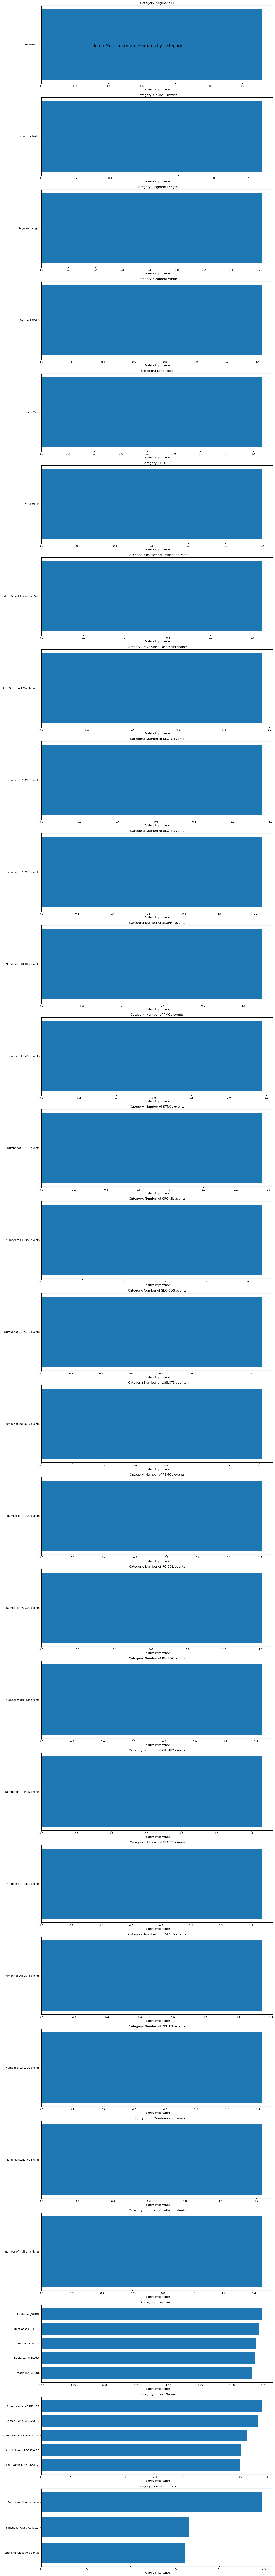

Top 5 Most Important Features by Category:

Segment ID:
Segment ID: 1.3166205883026123

Council District:
Council District: 1.2866626977920532

Segment Length:
Segment Length: 1.6283721923828125

Segment Width:
Segment Width: 1.4282171726226807

Lane Miles:
Lane Miles: 1.6644357442855835

PROJECT:
PROJECT_ID: 1.1994258165359497

Most Recent Inspection Year:
Most Recent Inspection Year: 1.0438969135284424

Days Since Last Maintenance:
Days Since Last Maintenance: 0.9671134948730469

Number of SLCT6 events:
Number of SLCT6 events: 1.1543742418289185

Number of SLCT5 events:
Number of SLCT5 events: 1.2373692989349365

Number of SLURRY events:
Number of SLURRY events: 1.0906010866165161

Number of PMOL events:
Number of PMOL events: 1.176283359527588

Number of STROL events:
Number of STROL events: 1.3613684177398682

Number of CRCKSL events:
Number of CRCKSL events: 1.073498249053955

Number of SLRYCDS events:
Number of SLRYCDS events: 1.4747133255004883

Number of LUSLCT5 events:
Number 

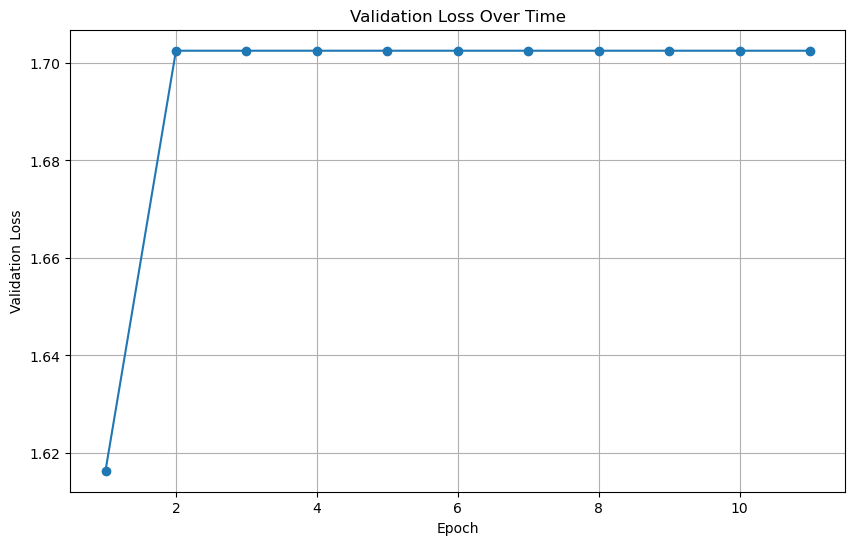


Validation Loss per Epoch:
Epoch 1: 1.6164
Epoch 2: 1.7025
Epoch 3: 1.7025
Epoch 4: 1.7025
Epoch 5: 1.7025
Epoch 6: 1.7025
Epoch 7: 1.7025
Epoch 8: 1.7025
Epoch 9: 1.7025
Epoch 10: 1.7025
Epoch 11: 1.7025

Analysis of Validation Loss:
The validation loss has not decreased. The model might be overfitting or struggling to learn.
Lowest validation loss: 1.6164 (Epoch 1)
Final validation loss: 1.7025
The validation loss increased in the final epoch, suggesting the model might be starting to overfit.


In [ ]:

def get_feature_importance(model, feature_names):
    importance = np.zeros(len(feature_names))
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_importance = np.abs(param.detach().cpu().numpy())
            if layer_importance.ndim == 2 and layer_importance.shape[1] == len(importance):
                importance += layer_importance.sum(axis=0)
            elif layer_importance.ndim == 1 and layer_importance.shape[0] == len(importance):
                importance += layer_importance
    return importance


# Get feature importance
feature_importance = get_feature_importance(best_model.model, feature_names)

# Create a dictionary of feature names and their importance
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Group features by category
feature_categories = defaultdict(dict)
for feature, importance in feature_importance_dict.items():
    category = feature.split('_')[0]  # Assuming category is the part before the first underscore
    feature_categories[category][feature] = importance

# Select top N features from each category
N = 5  # Number of top features to select from each category
top_features_by_category = {}
for category, features in feature_categories.items():
    sorted_features = sorted(features.items(), key=lambda x: x[1], reverse=True)
    top_features_by_category[category] = sorted_features[:N]

# Plotting
plt.figure(figsize=(15, 10))
categories = list(top_features_by_category.keys())
num_categories = len(categories)
num_features = N

fig, axs = plt.subplots(num_categories, 1, figsize=(15, 5*num_categories), squeeze=False)
fig.suptitle('Top 5 Most Important Features by Category', fontsize=16)

for i, category in enumerate(categories):
    features, importances = zip(*top_features_by_category[category])
    axs[i, 0].barh(features, importances)
    axs[i, 0].set_title(f'Category: {category}')
    axs[i, 0].set_xlabel('Feature Importance')
    axs[i, 0].invert_yaxis()

plt.tight_layout()
plt.show()

# Print the top features for each category
print("Top 5 Most Important Features by Category:")
for category, features in top_features_by_category.items():
    print(f"\n{category}:")
    for feature, importance in features:
        print(f"{feature}: {importance}")

# Interpret the results
print("\nInterpretation of Results:")
print("1. We can now see the most important features across different categories.")
print("2. This provides a more balanced view of feature importance across the dataset.")
print("3. Consider the top features from each category for further analysis or feature engineering.")
print("4. Compare the importance values across categories to understand which categories have the strongest influence overall.")



# Extract validation loss from metrics
val_losses = [x['val_loss'].item() for x in metrics_callback.metrics]

# Plot validation loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o')
plt.title('Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# Print the validation loss for each epoch
print("\nValidation Loss per Epoch:")
for epoch, loss in enumerate(val_losses, 1):
    print(f"Epoch {epoch}: {loss:.4f}")
    
# Analyze the validation loss trend
print("\nAnalysis of Validation Loss:")
if val_losses[-1] < val_losses[0]:
    print("The validation loss has decreased over time, indicating that the model is learning.")
    print(f"Total decrease in validation loss: {val_losses[0] - val_losses[-1]:.4f}")
else:
    print("The validation loss has not decreased. The model might be overfitting or struggling to learn.")

print(f"Lowest validation loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
print(f"Final validation loss: {val_losses[-1]:.4f}")

if len(val_losses) > 1:
    if val_losses[-1] < val_losses[-2]:
        print("The validation loss decreased in the final epoch, suggesting the model might benefit from more training.")
    else:
        print("The validation loss increased in the final epoch, suggesting the model might be starting to overfit.")





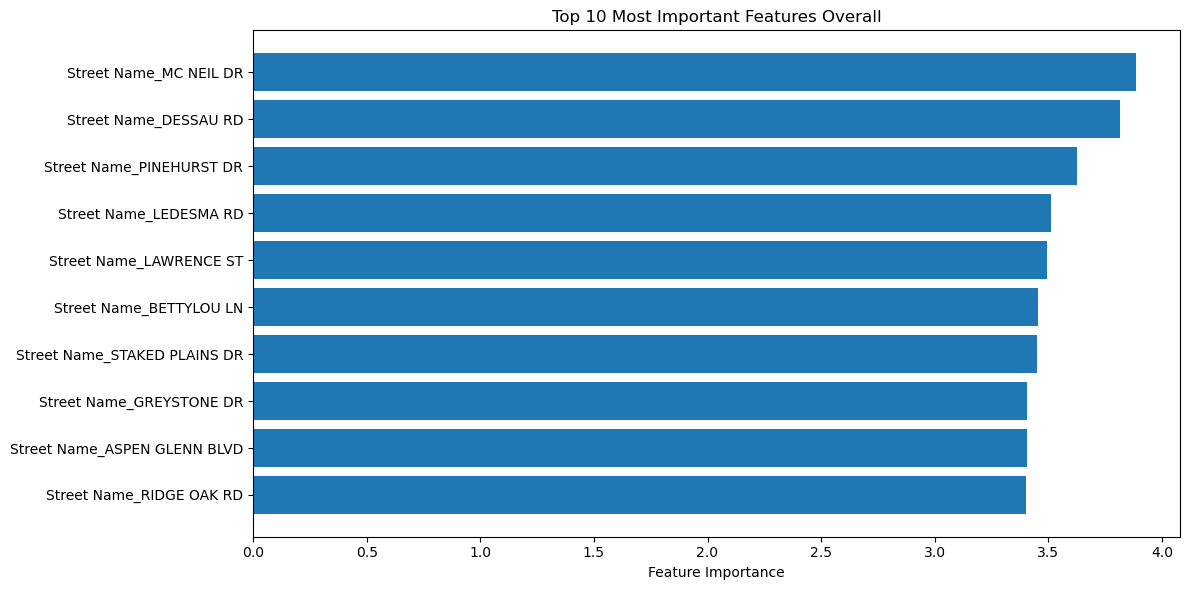

Top 10 Most Important Features Overall:
Street Name_MC NEIL DR: 3.885228157043457
Street Name_DESSAU RD: 3.8155593872070312
Street Name_PINEHURST DR: 3.624359130859375
Street Name_LEDESMA RD: 3.511039972305298
Street Name_LAWRENCE ST: 3.4928557872772217
Street Name_BETTYLOU LN: 3.4523439407348633
Street Name_STAKED PLAINS DR: 3.451608419418335
Street Name_GREYSTONE DR: 3.4053633213043213
Street Name_ASPEN GLENN BLVD: 3.404130220413208
Street Name_RIDGE OAK RD: 3.400604009628296


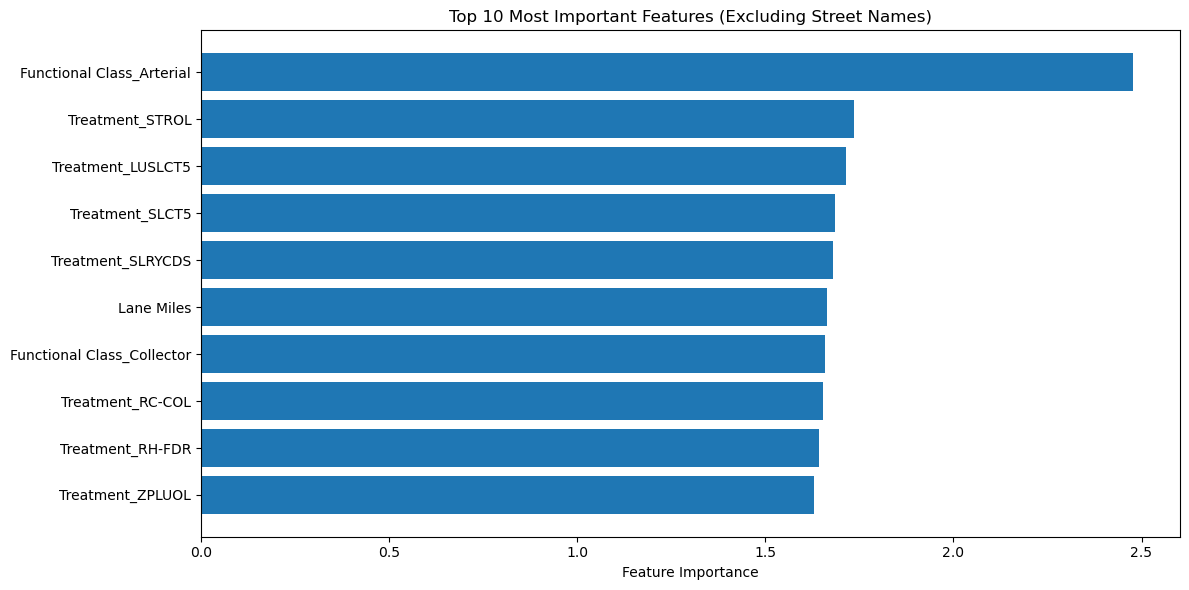

Top 10 Most Important Features (Excluding Street Names):
Functional Class_Arterial: 2.4783735275268555
Treatment_STROL: 1.7360365390777588
Treatment_LUSLCT5: 1.7137222290039062
Treatment_SLCT5: 1.685530662536621
Treatment_SLRYCDS: 1.6790339946746826
Lane Miles: 1.6644357442855835
Functional Class_Collector: 1.6588066816329956
Treatment_RC-COL: 1.654392123222351
Treatment_RH-FDR: 1.6429554224014282
Treatment_ZPLUOL: 1.6303240060806274


In [ ]:
# Sort all features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select top 10 features
top_10_features = sorted_features[:10]

# Plotting
plt.figure(figsize=(12, 6))
features, importances = zip(*top_10_features)
plt.barh(features, importances)
plt.title('Top 10 Most Important Features Overall')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.tight_layout()
plt.show()

# Print the top 10 features
print("Top 10 Most Important Features Overall:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")

# Filter out "Street Name" features
filtered_features = {k: v for k, v in feature_importance_dict.items() if not k.startswith("Street Name")}

# Sort filtered features by importance
sorted_filtered_features = sorted(filtered_features.items(), key=lambda x: x[1], reverse=True)

# Select top 10 features
top_10_filtered_features = sorted_filtered_features[:10]

# Plotting
plt.figure(figsize=(12, 6))
features, importances = zip(*top_10_filtered_features)
plt.barh(features, importances)
plt.title('Top 10 Most Important Features (Excluding Street Names)')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.tight_layout()
plt.show()

# Print the top 10 features
print("Top 10 Most Important Features (Excluding Street Names):")
for feature, importance in top_10_filtered_features:
    print(f"{feature}: {importance}")

